<a href="https://colab.research.google.com/github/aknew/IRE_scripts/blob/master/DataProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# постановка задачи
Имеется сигнал состоящий из тренда, полезного сигнала в виде коротких участков другого уровня и сильно выбивающихся выбросов. Это вполне реальная схема когда тренд пытаются убрать 
периодически измеряя излучение из среды без мишени(перекрывая полезный сигнал обтюратором [Ссылка на Пасечника] или же просто убирая мишень [Ссылка на одну из наших статей])

// TODO: мембранные поры?

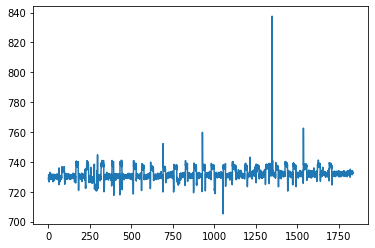

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data = np.loadtxt('https://gist.githubusercontent.com/aknew/86a8e59c1c7c2e0878876c770063f0e3/raw/1b267abc3f39bb2f18e18a31d06ec4752da8f243/samples.csv')

t = data[:, 0]
data = data[:, 1]
plt.plot(t,data)

t_raw = t
data_raw = data

# Функция для имитации данных и служебные функции

In [ ]:
def imitate_data():
  """
  функция имитирования данных, создает данные с линейным трендом и событиями
  количество, расположение и ширина событий случайны, линейный тренд также случаен
  Returns
  -------
  кортеж состоящий из времени, данных, событий (массив точек) и параметров событий (массив кортежей начало события-длина события)
  """
  rng = np.random.default_rng()
  points_number = 1000

  t = np.arange(points_number)

  # шумовая дорожка шириной в 10 единиц
  noise_width = 10
  y = rng.random(points_number)*noise_width

  # случайным образом раскидываем по дорожке события

  events_number = np.random.randint(3, high=11)
  events = []
  events_param = []
  event_zone_width = points_number/events_number
  for i in range(1, events_number+1):
    event_width = int(event_zone_width/3*rng.random())
    if event_width == 0:
      continue
    zone_start = event_zone_width*(i-1)
    zone_end = event_zone_width*i
    event_start = np.random.randint(zone_start, high=zone_end-event_width)
    event = rng.random(event_width) * noise_width + 50 # для начала событие это просто участок выше фона на 50 пунктов
    events.append(event)
    events_param.append((event_start, event_width))
    y[event_start:event_start+event_width] = event
    # plt.plot(event)

  # добавляем тренд
  p = rng.random(2)/10
  # y = y + np.polyval(p,t)
  # plt.plot(t, y)

  return (t, y, events, events_param)

In [ ]:
def events_from_params(y, params):
  """
  служебная функция для получения из изначального сигнала и списка параметров событий самих событий
  важный момент - я умышлено не делал проверку на выход за пределы массива для экономии времени, все-таки это скорее набросок a la proof of concept, чем реальная боевая программа
  
  Parameters
  ----------
  y
    сигнал
  params
    параметры событий
  
  Returns
  -------
  events
    события вырезанные из сигнала
  """
  events = []
  for param in params:
    event = y[param[0]:param[0]+param[1]]
    events.append(event)
  return events

In [ ]:
def signs_from_params(y, params):
  """
  служебная функция для получения из изначального сигнала и списка параметров событий разметки событие ли конкретная точка или подошва
  важный момент - я умышлено не делал проверку на выход за пределы массива для экономии времени, все-таки это скорее набросок a la proof of concept, чем реальная боевая программа
  
  Parameters
  ----------
  y
    сигнал
  params
    параметры событий
  
  Returns
  -------
  c
    разметка, если это событие то равно 1, иначе равно 0
  """
  c = np.zeros(len(y))
  for param in params:
    c[param[0]:param[0]+param[1]] = 1
  return c

# фильтрация выбросов
Эту задачу мы решили в лоб - поскольку выбросы у нас очень сильно выбиваются по уровню, то мы просто выкидываем все точки которые отличаются от среднего более чем на СКО умноженное на некоторый коэфициент (в нашем случае, коэфициент подобран имперически и составил 1.5)

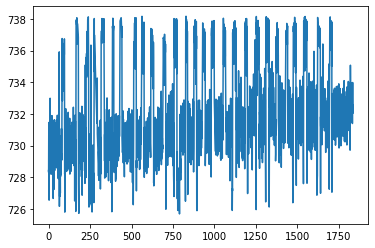

In [ ]:
std = data.std()

mean = data.mean()

coef = 1.5 # коэфициент, определяющий что считать выбросом (насколько далеко от среднего он оказывается)
flags = abs(data-mean)<coef*std

t = t[flags]
data = data[flags]

plt.plot(t,data)

# просто сохраняю переменные чтобы можно было использовать их в разных вариантах решения
dataOrig = data
torig = t

# определение тренда и разбитие сигнала на полезный сигнал и подошву

 Следующая задача - убрать тренд и отделить полезный сигнал от подошвы. ***Ниже представлены несколько вариантов решения. Они представляют собой функции определяющие события с одинаковым интерыейсом: на вход они принимают два массива - времени и отсчетов, а на выходе у них кортеж из массива отсчетов с убранным трендом и массива кортежей (начало события, длина события). Такой интерфейс выбран потому что в одном случае (акустотермография) нам по сути нужны только сами отсчеты внутри события, а в другом (мембранные поры) уже нужно вычислять некоторые параметры отличия события от фона***

## Вариант 1 - через Kmean

На самом деле настоящая постановка задачи тут была такая - я услышал что-то типа "студенты вручную размечают данные" и посчитал что в 21 веке в серьезном институте это не дело. Возможно, именно это стало причиной использования kmean - я именно что пытался автоматизировать то как смотрел бы человек, когда мы попытались обсудить что нам собственно нужно, то довольно быстро пришли к выводу что искать нужно не разные уровни, а наличие изменения уровня, что, судя по всему, ловится чисто по разнице с предыдущими точками т.е. производной без всякого ML

Основная идея тут довольно проста - поскольку полезный сигнал отстоит от подошвы, то запуск одномерного kmean на 2 класса должен разделить их когда в один более многочисленный класс (NB: с обтюратором не факт что это верно) попадет только подошва, а в другой - все полезные сигналы. На практике эксперимент шел долго и некоторые точки полезного сигнала из начала эксперимента (в случае нарастания тренда как у нас) оказывались на одном уровне с подошвой в конце эксперимента и одномерная кластеризация их  не может разделить (см. пример ниже)

3314 3314 3314


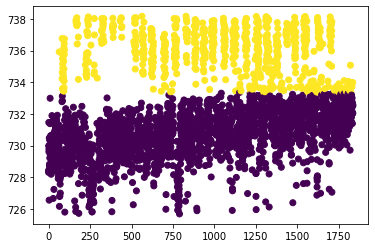

In [ ]:
from sklearn.cluster import KMeans

dataPredict = KMeans(n_clusters=2, random_state=0).fit_predict(data.reshape(-1,1))

# plt.scatter(t, data, c=dataPredict)

coef = 100000
data1 = data * coef
d = np.column_stack((t,data1))
dataPredict = KMeans(n_clusters=2, random_state=0).fit_predict(d)
print(len(data), len(d), len(dataPredict))
plt.scatter(t, data, c=dataPredict)


 для того чтобы это устранить мы проводим серию итераций:

In [ ]:
from sklearn.cluster import KMeans

def kmean_way(t, data):
  epsilon = 0.01
  flag = True
  iter = 0

  while flag:
    # используем kmean на наших данных
    dataPredict = KMeans(n_clusters=2, random_state=0).fit_predict(data.reshape(-1,1))

    # определяем самый большой класс и считаем его подошвой
    d0 = data[dataPredict == 0]
    d1 = data[dataPredict == 1]
    base = 0
    if len(d1) > len(d0):
      base = 1
    tt = t[dataPredict == base]
    dd = data[dataPredict == base]

    # по этому классу определяем тренд и вычитаем его из исходных данных
    p = np.polyfit(tt, dd, 1);
    trend = np.polyval(p,t);
    data = data - trend;
    iter += 1

    # если разница между min и max тренда больше некоторого эпсилон - повторяем процедуру
    trendForce = abs(max(trend)-min(trend))
    flag = trendForce > epsilon

  # plt.scatter(t, data, c=dataPredict)
  print("iter count:" + str(iter))
  event_start = -1
  events = []
  for i in range(1,len(dataPredict)):
    if dataPredict[i] != dataPredict[i-1]:
      if event_start == -1:
        event_start = i
      else:
        width = i - event_start
        events.append((event_start, width))
        event_start = -1
  
  return (data, events)

безусловным плюсом этого метода является то что в нем всего один настраеваемый параметр, да и тот точность (epsilon) с которой убирается тренд

# Вариант 2. Метод основанный на скользящем среднем и отклонении 
Настраеваемых параметров тут два - ширина окна для скользящего среднего и коэфициент при котором отклонение считается сильнее шума. Также стоит отметить что в зависимости от ширины окна для скользящено среднего и длины полезного сигнала величина отклонения довольно сильно плывет.

Также тут надо подумать как описать его простоту, судя по всему O-нотация у них одинаковая т.к. kmean O(N) (см. https://stackoverflow.com/questions/25362496/computing-complexity-of-kmeans-algorithm) и этот алгоритм O(N) (нужно пробежаться 5 раз по массиву в вычислении отклонения и по одному разу для разметки, вычислению тренда и вычитанию тренда), но этот алгоритм явно проще т.к. тут только среднее по N точкам и вычитание/сравнение, но в то же время похоже подбор двух коэфициентов более сложен

Также имеется еще такой интересный момент - для сгенерированных данных мне попадались события на которых у статичтического метода не совпадало начало (крайне редко) и длина события, для kmean я такой проблемы не видел

In [ ]:
def statistics_way(t, data):

  w = 5
  coef = 2 #1.5
  # считаем отклонение от скользящего среднего по 5 предыдущим элментам
  data_len = len(data)
  m = np.zeros(data_len)
  d = np.zeros(data_len)
  for i in range(w-2,data_len):
    # print("i=",i)
    rm = data[i-w+1:i].mean()
    m[i] = rm
    dif = data[i]-rm
    d[i] = dif

  std = np.nanstd(d) #d.std()
  
  tt = np.array([])
  dataBackground = np.array([])
  previous_index = 0
  events =[]
  treshold = coef*std
  isEvent = False
  pivots = []
  for i in range(0,data_len):
    if d[i] > treshold and not isEvent:
      isEvent = True
      dataBackground = np.append(dataBackground, data[previous_index+1:i-1])
      tt = np.append(tt, t[previous_index+1:i-1])
      previous_index = i
    elif d[i] < -treshold and isEvent:
      isEvent = False
      events.append((previous_index, i - previous_index))
      previous_index = i

  dataBackground = np.append(dataBackground, data[previous_index+1:data_len-1])
  tt = np.append(tt, t[previous_index+1:data_len-1])
  p = np.polyfit(tt, dataBackground, 1)
  trend = np.polyval(p,t)
  data = data - trend;
  

  # отображаем точки на которые мы опираемся
  tp = []
  dp = []
  for event in events:
    tp.append(t[event[0]])
    tp.append(t[event[0]+event[1]])
    dp.append(d[event[0]])
    dp.append(d[event[0]+event[1]])

  c = signs_from_params(data, events)
  
  # TODO: построить гистограмму отклонения от std
  ddd = np.ones(data_len)*treshold

  # fig, axs = plt.subplots(3)
  # fig.suptitle('Vertically stacked subplots')
  # #axs[0].plot(t, data)
  # axs[0].scatter(t, data, c=c)
  # axs[1].plot(t, m)
  # axs[2].plot(t, d)
  # axs[2].plot(t, ddd,'r')
  # axs[2].plot(t, -ddd,'r')
  # axs[2].plot(tp, dp,'.g')

  # plt.plot(t, d)
  # plt.plot(t, ddd,'r')
  # plt.plot(t, -ddd,'r')

  # plt.plot(t[abs(d)>treshold],d[abs(d)>treshold],'ys')

  # plt.plot(tp, dp,'.g')

  return (data, events)


# Испытания алгоритмов

In [ ]:
# на тестовых данных
(t, y, events, events_param) = imitate_data()
print("original data ", events_param)
# TODO: добавить сохранение данных - если что-то пойдет не так неплохо было бы иметь данные на которых тот или иной алгоритм падает
(y_kmean, event_param_kmean) = kmean_way(t, y)
print("kmean result  ", event_param_kmean)
(y_stat, event_param_stat) = statistics_way(t, y)
print("stat result   ", event_param_stat)

print("----------")
kmean_events = events_from_params(y_kmean, event_param_kmean)
event_error = []
for e, ce in zip(events, kmean_events):
  error = e - ce
  event_error.append(error.std())

print("kmean error   ", event_error)

stat_events = events_from_params(y_stat, event_param_stat)
event_error = []
for e, ce in zip(events, stat_events):
  # TODO: тут нужно вставить проверку на совпадение начла и длины события, формально ее нужно вставить и выше, но для kmean я такой проблемы не видел
  error = e - ce
  event_error.append(error.std())

print("stat error    ", event_error)

original data  [(69, 11), (282, 43), (685, 45), (859, 65)]
iter count:2
kmean result   [(69, 11), (282, 43), (685, 45), (859, 65)]
stat result    [(69, 11), (282, 43), (685, 45), (859, 65)]
----------
kmean error    [0.0006028299789810155, 0.0023656756639055727, 0.0024757653071349256, 0.0035765654224754035]
stat error     [0.0008499494601607875, 0.0033354425353068983, 0.003490661479444341, 0.005042715120438515]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


iter count:4
[(19, 1), (127, 1), (159, 31), (203, 1), (295, 1), (327, 10), (375, 1), (416, 1), (420, 19), (466, 1), (503, 5), (509, 1), (544, 16), (590, 1), (649, 9), (726, 6), (865, 21), (948, 25), (1049, 33), (1174, 1), (1193, 29), (1280, 1), (1295, 1), (1304, 1), (1318, 33), (1448, 18), (1539, 27), (1630, 29), (1729, 34), (1853, 27), (1959, 32), (1992, 7), (2027, 1), (2044, 1), (2056, 1), (2103, 28), (2201, 1), (2216, 1), (2220, 2), (2223, 2), (2233, 12), (2246, 22), (2279, 1), (2288, 1), (2334, 1), (2346, 36), (2392, 1), (2416, 1), (2420, 3), (2459, 28), (2501, 1), (2566, 10), (2636, 31), (2754, 32), (2811, 1), (2869, 1), (2871, 2), (2914, 21), (2965, 1), (3037, 1), (3044, 19), (3283, 1)]


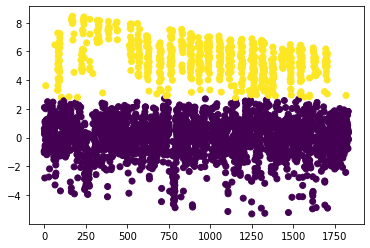

In [ ]:
# на реальных данных

(y_kmean, event_param_kmean) = kmean_way(torig, dataOrig)
c = signs_from_params(dataOrig, event_param_kmean)
plt.scatter(torig, y_kmean, c=c)
print(event_param_kmean)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[(127, 1), (160, 30), (327, 10), (416, 23), (443, 26), (503, 5), (544, 16), (649, 9), (726, 6), (865, 21), (891, 82), (1049, 33), (1193, 30), (1318, 33), (1382, 65), (1448, 18), (1539, 27), (1630, 29), (1729, 34), (1853, 27), (1959, 40), (2027, 104), (2220, 10), (2233, 35), (2334, 10), (2346, 36), (2386, 101), (2566, 10), (2636, 31), (2754, 32), (2790, 83), (2913, 22), (2940, 123)]


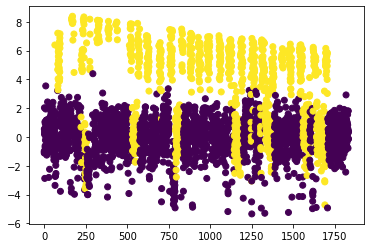

In [ ]:
# part = 500
# ttt = torig[0:part]
# ddd = dataOrig[0:part]
ttt = torig
ddd = dataOrig
(y_stat, event_param_stat) = statistics_way(ttt, ddd)
c = signs_from_params(ddd, event_param_stat)
plt.scatter(torig, y_stat, c=c)
print(event_param_stat)

Допуски:
- попадание мишени не влияет на тренд (при ее наличии и без нее тренд одинаков)
- тренд монотонный
- подошва больше чем сигнал по количеству точек
- сигнал всегда с одной стороны от подошвы (или придется делать модификацию с 3 классами)

TODO: kmean c известным числом классов - это позволит в итоге обойтись одной итерацией, но нужно будет добавлять обрабртку на группировку классов

TODO: курс от яндекс ШАД - там было что-то про вариант классификации когда все разбивается на отдельные точки-классы и потом уже эти классы укрупняются на основании расстояния между классами. Возможно, это описание kmean